# Zonal Statistics


# Introduction to code
1. calculate zonal statistics for (indirect nutrient load/stream)WatershedPourPoints_LH.shp
2. Calculate Zonal statistics for (direct nutrient flux/coastal wetland corresponding watershed)wetland_connected_avg_inundation_NAD1983_Watershed
3. Subtract the values of flux that have overlap 

# Zonal Statistics for Coastal Watersheds

This notebook calculates zonal statistics/Nutrient flux for the coastal watersheds in the Great Lakes region.


## Objectives:
1. **Integrate Coastal Watershed Data**:
   - Utilize the delineated coastal watersheds as zones for statistical analysis.

2. **Compute Spatial Metrics**:
   - Perform calculations, such as mean, sum, and area-weighted averages, for variables like:
     - Land use types.
     - Vegetation cover.
     - Hydrological properties.

3. **Export Results for Further Analysis**:
   - Aggregate and save the results in a structured format to facilitate downstream analysis and visualization.

## Workflow:
1. **Data Loading**:
   - Import relevant spatial datasets, including raster and vector files.
   - Integrate delineated coastal watershed data from previous analyses.

2. **Zonal Statistics Calculation**:
   - Apply zonal statistics tools to compute desired metrics over each watershed zone.

3. **Result Validation and Export**:
   - Validate calculated statistics.
   - Export the results as tables or geospatial files for further use.

---

This notebook is a critical step in quantifying spatial characteristics within the Great Lakes coastal watersheds, supporting environmental management and decision-making.


# Required Imports

In [1]:
### Reqiured Imports###
import pandas, os
import arcpy
import pandas as pd
import geopandas as gpd
import numpy as np
from arcpy.sa import *
import matplotlib.pyplot as plt

# Inputs

In [3]:
# =========================
# FULL UPDATED PATHS CELL
# =========================
import os
import geopandas as gpd
import arcpy

# ---- Base paths ----
base_path = r'D:\Users\abolmaal\Arcgis\NASAOceanProject'
nutrient_flux_path = os.path.join(base_path, 'Luwen_Nutrient')
coastal_watersheds_path = os.path.join(base_path, 'GIS_layer', 'CoastalWatersheds')

# ---- Stream watershed DB folder ----
inDB = os.path.join(base_path, 'GIS_layer', 'Streamwatershed')

# ---- Nutrient flux rasters ----
inBYRaster_TN = os.path.join(nutrient_flux_path, 'TN_Annual_delTotal_header_kgcellday.tif')
inBYRaster_TP = os.path.join(nutrient_flux_path, 'TP_Annual_delTotal_header_kgcellday.tif')

# ---- Input feature classes ----
inPourpoint = 'WatershedPourPoints_NAD1983'
inWatershed = os.path.join(inDB, 'PointWatershed_LH_NAD1983_NASA_Invasive.shp')

# ---- Coastal watersheds folder (IMPORTANT: this is the folder that contains the shapefiles) ----
inCW = os.path.join(coastal_watersheds_path, "Erase_Lake")

# Use FILENAMES ONLY here (so later we do os.path.join(inCW, filename))
inCoastalWatershed_avg   = 'CoastalWatershed_avg_erase_lakedrain_LakeHuron.shp'
inCoastalWatershed_low   = 'CoastalWatershed_low_erase_lakedrain_LakeHuron.shp'
inCoastalWatershed_high  = 'CoastalWatershed_high_erase_lakedrain_LakeHuron.shp'
inCoastalWatershed_surge = 'CoastalWatershed_surge_erase_lakedrain_LakeHuron.shp'

# Full paths (these are what you should pass to arcpy)
fcCoastalWatershed_avg   = os.path.join(inCW, inCoastalWatershed_avg)
fcCoastalWatershed_low   = os.path.join(inCW, inCoastalWatershed_low)
fcCoastalWatershed_high  = os.path.join(inCW, inCoastalWatershed_high)
fcCoastalWatershed_surge = os.path.join(inCW, inCoastalWatershed_surge)

# ---- Coastal wetlands folder ----
# (these are the wetlands shapefiles where you removed the 50 m riparian buffer overlap with stream watersheds)
incoastalwetland = os.path.join(coastal_watersheds_path, "Erase_Riperian")

# Read wetlands into GeoDataFrames
inCoastalWetland_avg   = gpd.read_file(os.path.join(incoastalwetland, 'Wetland_connected_avg_erasebuff_50.shp'))
inCoastalWetland_low   = gpd.read_file(os.path.join(incoastalwetland, 'Wetland_connected_low_erasebuff_50.shp'))
inCoastalWetland_high  = gpd.read_file(os.path.join(incoastalwetland, 'Wetland_connected_high_erasebuff_50.shp'))
inCoastalWetland_surge = gpd.read_file(os.path.join(incoastalwetland, 'Wetland_connected_surge_erasebuff_50.shp'))

# ---- Outputs ----
outTable = 'direct_coastal_N_P_wetland_loads'
outFeature = 'wetland_connected_avg_inundation_Albers'

# ---- ArcPy environment ----
arcpy.env.overwriteOutput = True
arcpy.env.workspace = inDB

# ---- Quick sanity checks (prints True/False so you immediately see what’s wrong) ----
def _chk(label, p):
    print(f"{label:30s} | os.exists={os.path.exists(p)} | arcpy.Exists={arcpy.Exists(p)}")
    
_chk("inDB", inDB)
_chk("inWatershed", inWatershed)
_chk("inCW (Erase_Lake folder)", inCW)
_chk("CW avg", fcCoastalWatershed_avg)
_chk("CW low", fcCoastalWatershed_low)
_chk("CW high", fcCoastalWatershed_high)
_chk("CW surge", fcCoastalWatershed_surge)
_chk("Wetlands folder", incoastalwetland)
_chk("TN raster", inBYRaster_TN)
_chk("TP raster", inBYRaster_TP)


inDB                           | os.exists=True | arcpy.Exists=True
inWatershed                    | os.exists=True | arcpy.Exists=True
inCW (Erase_Lake folder)       | os.exists=True | arcpy.Exists=True
CW avg                         | os.exists=True | arcpy.Exists=True
CW low                         | os.exists=True | arcpy.Exists=True
CW high                        | os.exists=True | arcpy.Exists=True
CW surge                       | os.exists=True | arcpy.Exists=True
Wetlands folder                | os.exists=True | arcpy.Exists=True
TN raster                      | os.exists=True | arcpy.Exists=True
TP raster                      | os.exists=True | arcpy.Exists=True


In [ ]:
# read inCoastalWatershed_avg shapefile into GeoDataFrame and inCoastalWetland_avg shapefile into GeoDataFrame and compare the lengths
dfCoastalWatershed_avg = gpd.read_file(fcCoastalWatershed_avg)
# dfCoastalWetland_avg = gpd.read_file(os.path.join(incoastalwetland, 'Wetland_connected_avg_erasebuff_50.shp'))
# print("Length of dfCoastalWatershed_avg:", len(dfCoastalWatershed_avg))
# print("Length of dfCoastalWetland_avg:", len(dfCoastalWetland_avg))

In [ ]:
# print InCoastalWatershed_high columns
print("Columns in inCoastalWatershed_avg:", dfCoastalWatershed_avg.columns.tolist())

In [ ]:
# remove column [FOD_Wetlan,Id_1,FID_lh_sho,Id_12,ORIG_FID] from the inCoastalWetland_avg, inCoastalWetland_low, inCoastalWetland_high, inCoastalWetland_surge dataframes
# inCoastalWetland_avg = inCoastalWetland_avg.drop(columns=['FID_Wetlan','Id_1','FID_lh_sho'])
# inCoastalWetland_low = inCoastalWetland_low.drop(columns=['FID_Wetlan','Id_1','FID_lh_sho'])
# inCoastalWetland_high = inCoastalWetland_high.drop(columns=['FID_Wetlan','Id_1','FID_lh_sho'])
# inCoastalWetland_surge = inCoastalWetland_surge.drop(columns=['FID_Wetlan','Id_1','FID_lh_sho'])

# Outputs

In [4]:
outBYRaster_TN =  os.path.join(nutrient_flux_path, 'TN_Annual_kgcellday_header_kgcellday_converted.tif')
outByRaster_TP =  os.path.join(nutrient_flux_path, 'TP_Annual_delTotal_header_kgcellday_converted.tif')

# out path
outDb = os.path.join(base_path, 'ZonalStats')

# Fields to calculate / Direct delivery to Watersheds
StreamDirectTN = 'StreamDirectTN_kgday'
StreamDirectTN_converted = 'StreamDirectTN_grm2yr'
StreamDirectTP = 'StreamDirectTP_kgday'
StreamDirectTN_converted = 'StreamDirectTN_grm2yr'
# out name for the zonal stats Stream watersheds
outStreamWatershed = os.path.join(outDb, 'DirectTNTP_StreamWatresheds.csv')



# Direct delivery to Coastal Watersheds
CoastalDirectTN_avg = 'CoastalWatershedDirectTN_avg_kgday'
CoastalDirectTN_avg_convert = 'CoastalWatershedDirectTN_avg_grm2yr'
CoastalDirectTP_avg = 'CoastalWatershedDirectTP_avg_kgday'
CoastalDirectTP_avg_convert = 'CoastalWatershedDirectTP_avg_grm2yr'


CoastalDirectTN_low = 'CoastalWatershedDirectTN_low_kgday'
CoastalDirectTN_low_convert = 'CoastalWatershedDirectTN_low_grm2yr'
CoastalDirectTP_low = 'CoastalWatershedDirectTP_low_kgday'
CoastalDirectTP_low_convert = 'CoastalWatershedDirectTP_low_grm2yr'


CoastalDirectTN_high = 'CoastalWatershedDirectTN_high_kgday'
CoastalDirectTN_high_convert = 'CoastalWatershedDirectTN_high_grm2yr'
CoastalDirectTP_high_convert = 'CoastalWatershedDirectTP_high_grm2yr'
CoastalDirectTP_high = 'CoastalWatershedDirectTP_high_kgday'

CoastalDirectTN_surge = 'CoastalWatershedDirectTN_surge_kgday'
CoastalDirectTN_surge_convert = 'CoastalWatershedDirectTN_surge_grm2yr'
CoastalDirectTP_surge = 'CoastalWatershedDirectTP_surge_kgday'
CoastalDirectTP_surge_convert = 'CoastalWatershedDirectTP_surge_grm2yr'

# out names to save the zonal stats for the coastal watersheds
outCoastalWatershed_avg = os.path.join(outDb, 'DirectTNTP_CoastalWatershed_avg_2.csv')
outCoastalWatershed_low = os.path.join(outDb, 'DirectTNTP_CoastalWatershed_low_2.csv')
outCoastalWatershed_high = os.path.join(outDb, 'DirectTNTP_CoastalWatershed_high_2.csv')
outCoastalWatershed_surge = os.path.join(outDb, 'DirectTNTP_CoastalWatershed_surge_2.csv')

outFig = os.path.join(base_path, 'figures')


# Parameters

In [5]:
# define the watershed number, 
# this number is the same as the FID number and it is used to number the watersheds and we will use this for particle tracking
# define the watershed number
watershed_num = "Group_id"
#Area = 'CW_Area'
# define the coastal wetland number which is same as FID number+1
Coastal_num = "CW_Id"
# coastal id is a unique number that is equal to = ID * 1000 + Coastal_num
Coastal_ID = 'Coastal_Id'
# coastal wetland fields
CoastalWetland_Area = "CW_Aream2"
lat_col_CW ="CW_cx"
lon_col_CW ="CW_cy"
# coastal watershed fields 
CoastalWatershed_Area = "WS_AREAM2"
lat_col_W ="WS_cx"
lon_col_W ="WS_cy"

In [5]:
# Shared columns
lat_col = "start_lat"
lon_col = "start_lon"
id_col = "CW_Id"
drop_cols = ['coastal_watershed_area','geometry']  # modify if others exist

# Main Functions

## Function to convert units from kg/day to gram/m2/year

In [6]:
def convert_kgday_to_grm2yr(df, kgday_col, area_col, new_col):
    """
    Converts values from kg/day to grams/m²/year.

    Parameters:
    - df: DataFrame containing the data
    - kgday_col: Column with kg/day values
    - area_col: Column with area in m²
    - new_col: Name of the output column (g/m²/year)
    """
    df[new_col] = ((df[kgday_col] * 1000 * 365) / df[area_col])


## Direct Nutrient Load to Stream Watersheds

####  Bring in Streamwatershed into a pandas dataframe and get the specific columns


In [ ]:
# Bring in Stream watersheds into a pandas dataframe and get the specific columns

dfWatershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inDB,inWatershed), [watershed_num, 'gridcode','Shape_Area']))

### Estimate Zonal statistics for StreamWatreshed
Bring in the nutrient flux rasters into a pandas dataframe and estimate the total nutrient load in the Streamwatershed

In [ ]:
# 1- calculate the zonal statistics with arcpy for inWatershed using inBYRaster
inZonalTN_watershed = arcpy.sa.ZonalStatisticsAsTable(inWatershed, watershed_num, inBYRaster_TN, 'SUM' ,'DATA')

# # bring in inWatershed and inZonalTN_watershed as pandas dataframes
dfZonalTN_watershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_watershed,
                                                                  [watershed_num, 'AREA','SUM']))
#rename the SUM field to fieldDirectTN
dfZonalTN_watershed.rename(columns={'SUM': StreamDirectTN}, inplace=True)
dfZonalTN_watershed

In [ ]:
inZonalTP_watershed = arcpy.sa.ZonalStatisticsAsTable(inWatershed,watershed_num, inBYRaster_TP, 'SUM' ,'DATA')
dfZonalTP_watershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_watershed, 
                                                                   [watershed_num, 'AREA','SUM']))
# rename the SUM field to fieldDirectTP
dfZonalTP_watershed.rename(columns={'SUM': StreamDirectTP}, inplace=True)

dfZonalTP_watershed

###  Merge Streamwatershed for TN and TP

In [ ]:
# merge dfWateshed with dfZonalTN_watershed where dfWateshed['Group_id'] = dfZonalTN_watershed['Group_id']
dfWatershed = dfWatershed.merge(dfZonalTP_watershed, left_on= watershed_num, right_on= watershed_num, how='inner')
# merge dfWateshed with dfZonalTN_watershed where dfWateshed['Group_id'] = dfZonalTN_watershed['Group_id']
dfWatershed = dfWatershed.merge(dfZonalTN_watershed, left_on=watershed_num, right_on=watershed_num, how='inner')
dfWatershed.describe()

In [ ]:
# remove the unnecessary columns from dfWatershed
dfWatershed.drop(columns=['AREA_x','AREA_y'], inplace=True)


### Save stream watershed Nutrient load

In [ ]:
# Save the dfWateshed to a csv file in the inDB directory with the name of Watresheds_total_N_P.csv
dfWatershed.to_csv(os.path.join(outDb, outStreamWatershed), index=False)

In [ ]:
# delete the extra columns then save them and rename them that make sense
# convert dfWatershed to a pandas dataframe
dfWatershed_pd = pd.DataFrame(dfWatershed)
# save dfWatershed_pd to a shape file in outDb with name outTable + '.shp'
dfWatershed_pd.to_csv(os.path.join(outDb, outTable + '.shp'))

## 2- Zonal Statistics for Coastal Watershed for Different Innundation

Calculate the zonal statistics with arcpy for inCoastawateshed using inBYRaster_TN, and inBYRaster_TP


In [7]:
#bring in the coastalwatreshed

dfCoastalWatershed_avg = pandas.DataFrame(
    arcpy.da.TableToNumPyArray(
        os.path.join(inCW, inCoastalWatershed_avg),
        [Coastal_num, CoastalWatershed_Area, lat_col_W, lon_col_W]
    )
)

dfCoastalWatershed_low = pandas.DataFrame(
    arcpy.da.TableToNumPyArray(
        os.path.join(inCW, inCoastalWatershed_low),
        [Coastal_num, CoastalWatershed_Area, lat_col_W, lon_col_W]
    )
)

dfCoastalWatershed_high = pandas.DataFrame(
    arcpy.da.TableToNumPyArray(
        os.path.join(inCW, inCoastalWatershed_high),
        [Coastal_num, CoastalWatershed_Area, lat_col_W, lon_col_W]
    )
)

dfCoastalWatershed_surge = pandas.DataFrame(
    arcpy.da.TableToNumPyArray(
        os.path.join(inCW, inCoastalWatershed_surge),
        [Coastal_num, CoastalWatershed_Area, lat_col_W, lon_col_W]
    )
)


#### Average Innundation

In [8]:
# Zonal stats tables
inZonalTN_coastal_avg = arcpy.sa.ZonalStatisticsAsTable(
    fcCoastalWatershed_avg, Coastal_num, inBYRaster_TN,
    out_table="in_memory\\ztn_avg", ignore_nodata="DATA", statistics_type="SUM"
)
inZonalTP_coastal_avg = arcpy.sa.ZonalStatisticsAsTable(
    fcCoastalWatershed_avg, Coastal_num, inBYRaster_TP,
    out_table="in_memory\\ztp_avg", ignore_nodata="DATA", statistics_type="SUM"
)

# Read zonal outputs
dfZonalTN_coastal_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_avg, [Coastal_num, "SUM"]))
dfZonalTP_coastal_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_avg, [Coastal_num, "SUM"]))

# Rename SUM -> your target column names
dfZonalTN_coastal_avg.rename(columns={"SUM": CoastalDirectTN_avg}, inplace=True)
dfZonalTP_coastal_avg.rename(columns={"SUM": CoastalDirectTP_avg}, inplace=True)

# Merge into watershed DF
dfCoastalWatershed_avg = dfCoastalWatershed_avg.merge(dfZonalTN_coastal_avg, on=Coastal_num, how="inner")
dfCoastalWatershed_avg = dfCoastalWatershed_avg.merge(dfZonalTP_coastal_avg, on=Coastal_num, how="inner")


### High inundation 


In [10]:
# Zonal stats tables
inZonalTN_coastal_high = arcpy.sa.ZonalStatisticsAsTable(
    fcCoastalWatershed_high, Coastal_num, inBYRaster_TN,
    out_table="in_memory\\ztn_high", ignore_nodata="DATA", statistics_type="SUM"
)
inZonalTP_coastal_high = arcpy.sa.ZonalStatisticsAsTable(
    fcCoastalWatershed_high, Coastal_num, inBYRaster_TP,
    out_table="in_memory\\ztp_high", ignore_nodata="DATA", statistics_type="SUM"
)

# Read zonal outputs
dfZonalTN_coastal_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_high, [Coastal_num, "SUM"]))
dfZonalTP_coastal_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_high, [Coastal_num, "SUM"]))

# Rename SUM -> your target column names
dfZonalTN_coastal_high.rename(columns={"SUM": CoastalDirectTN_high}, inplace=True)
dfZonalTP_coastal_high.rename(columns={"SUM": CoastalDirectTP_high}, inplace=True)

# Merge into watershed DF
dfCoastalWatershed_high = dfCoastalWatershed_high.merge(dfZonalTN_coastal_high, on=Coastal_num, how="inner")
dfCoastalWatershed_high = dfCoastalWatershed_high.merge(dfZonalTP_coastal_high, on=Coastal_num, how="inner")

### Low inundation


In [11]:
# Zonal stats tables
inZonalTN_coastal_low = arcpy.sa.ZonalStatisticsAsTable(
    fcCoastalWatershed_low, Coastal_num, inBYRaster_TN,
    out_table="in_memory\\ztn_low", ignore_nodata="DATA", statistics_type="SUM"
)
inZonalTP_coastal_low = arcpy.sa.ZonalStatisticsAsTable(
    fcCoastalWatershed_low, Coastal_num, inBYRaster_TP,
    out_table="in_memory\\ztp_low", ignore_nodata="DATA", statistics_type="SUM"
)

# Read zonal outputs
dfZonalTN_coastal_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_low, [Coastal_num, "SUM"]))
dfZonalTP_coastal_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_low, [Coastal_num, "SUM"]))

# Rename SUM -> your target column names
dfZonalTN_coastal_low.rename(columns={"SUM": CoastalDirectTN_low}, inplace=True)
dfZonalTP_coastal_low.rename(columns={"SUM": CoastalDirectTP_low}, inplace=True)

# Merge into watershed DF
dfCoastalWatershed_low = dfCoastalWatershed_low.merge(dfZonalTN_coastal_low, on=Coastal_num, how="inner")
dfCoastalWatershed_low = dfCoastalWatershed_low.merge(dfZonalTP_coastal_low, on=Coastal_num, how="inner")

### Surge inundation


In [12]:
# Zonal stats tables
inZonalTN_coastal_surge = arcpy.sa.ZonalStatisticsAsTable(
    fcCoastalWatershed_surge, Coastal_num, inBYRaster_TN,
    out_table="in_memory\\ztn_surge", ignore_nodata="DATA", statistics_type="SUM"
)
inZonalTP_coastal_surge = arcpy.sa.ZonalStatisticsAsTable(
    fcCoastalWatershed_surge, Coastal_num, inBYRaster_TP,
    out_table="in_memory\\ztp_surge", ignore_nodata="DATA", statistics_type="SUM"
)

# Read zonal outputs
dfZonalTN_coastal_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_surge, [Coastal_num, "SUM"]))
dfZonalTP_coastal_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_surge, [Coastal_num, "SUM"]))

# Rename SUM -> your target column names
dfZonalTN_coastal_surge.rename(columns={"SUM": CoastalDirectTN_surge}, inplace=True)
dfZonalTP_coastal_surge.rename(columns={"SUM": CoastalDirectTP_surge}, inplace=True)

# Merge into watershed DF
dfCoastalWatershed_surge = dfCoastalWatershed_surge.merge(dfZonalTN_coastal_surge, on=Coastal_num, how="inner")
dfCoastalWatershed_surge = dfCoastalWatershed_surge.merge(dfZonalTP_coastal_surge, on=Coastal_num, how="inner")

In [13]:
dfCoastalWatershed_avg.columns

Index(['CW_Id', 'WS_AREAM2', 'WS_cx', 'WS_cy',
       'CoastalWatershedDirectTN_avg_kgday',
       'CoastalWatershedDirectTP_avg_kgday'],
      dtype='object')

### Merge costal watershed with coastal wetlands 
Now I estimate the Zonal States for the Coastal watershed i will assign the values to coastal wetlands by merging the values of coastal watersheds to the coastal wetlands
1- convert the coastal watersheds and coastal wetland to pandas dataframe
2- merge two dataframes on coastal_num
3- find the missing values from the nearest coastal wetlands values 

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

def merge_and_fill_from_nearest_wetland(
    coastal_wetlands_df: gpd.GeoDataFrame,
    coastalwatershed_df: gpd.GeoDataFrame,
    id_column: str,
    tn_column: str,
    tp_column: str,
    drop_cols: list = None
):
    """
    Merge coastal wetlands with coastal watershed values (by CW_Id), and for any wetlands
    missing TN/TP, fill them by finding the nearest wetland that has valid TN/TP.

    Parameters:
    - coastal_wetlands_df: GeoDataFrame of all wetlands (e.g. avg, high, low, surge)
    - coastalwatershed_df: GeoDataFrame of watersheds with TN/TP values
    - id_column: common ID column, e.g., 'CW_Id'
    - tn_column, tp_column: column names for TN and TP to merge/fill
    - drop_cols: optional list of column names to drop from final output

    Returns:
    - GeoDataFrame of wetlands with TN/TP filled
    """
    # Step 1: Drop duplicates from watershed side (preserve wetlands length)
    coastalwatershed_df = coastalwatershed_df.drop_duplicates(subset=[id_column])

    # Step 2: Initial left merge (wetlands preserved)
    merged = coastal_wetlands_df.merge(
        coastalwatershed_df[[id_column, tn_column, tp_column]],
        on=id_column,
        how='left'
    )

    # Step 3: Identify missing rows
    missing = merged[merged[tn_column].isna() | merged[tp_column].isna()]
    print(f"🔎 Missing values before nearest fill: {len(missing)}")

    # Step 4: Create spatial index from wetlands that DO have values
    valid_wetlands = merged.dropna(subset=[tn_column, tp_column]).copy()
    sindex = valid_wetlands.sindex

    # Step 5: Loop through missing rows, find nearest valid wetland, assign TN/TP
    for idx, row in missing.iterrows():
        geom = row.geometry
        nearest_idx = list(sindex.nearest(geom, 1))[0]
        nearest_row = valid_wetlands.iloc[nearest_idx]

        # Assign values
        merged.at[idx, tn_column] = float(nearest_row[tn_column].iloc[0])
        merged.at[idx, tp_column] = float(nearest_row[tp_column].iloc[0])

    # Step 6: Drop optional columns
    if drop_cols:
        merged = merged.drop(columns=drop_cols, errors='ignore')

    # Step 7: Final check
    print(f"✅ Final missing TN: {merged[tn_column].isna().sum()}")
    print(f"✅ Final missing TP: {merged[tp_column].isna().sum()}")
    print(f"📏 Final row count: {len(merged)} (should match wetlands input: {len(coastal_wetlands_df)})")

    return merged

In [21]:
print(inCoastalWetland_avg[Coastal_num].duplicated().sum())
print(inCoastalWetland_low[Coastal_num].duplicated().sum())
print(inCoastalWetland_high[Coastal_num].duplicated().sum())
print(inCoastalWetland_surge[Coastal_num].duplicated().sum())

4
4
5
7


In [ ]:
# rename the column CW_Area to coastal_watershed_area in all coastal watersheds dataframes
dfCoastalWatershed_avg.rename(columns={'CW_Area': 'coastal_watershed_area'}, inplace=True)
dfCoastalWatershed_low.rename(columns={'CW_Area': 'coastal_watershed_area'}, inplace=True)
dfCoastalWatershed_high.rename(columns={'CW_Area': 'coastal_watershed_area'}, inplace=True)
dfCoastalWatershed_surge.rename(columns={'CW_Area': 'coastal_watershed_area'}, inplace=True)

In [ ]:
# Ensure CRS matches the wetlands dataframe
# Convert to GeoDataFrame using lat/lon from the watershed file
dfCoastalWatershed_avg = gpd.GeoDataFrame(
    dfCoastalWatershed_avg,
    geometry=gpd.points_from_xy(dfCoastalWatershed_avg['cent_lon'], dfCoastalWatershed_avg['cent_lat']),
    crs=inCoastalWetland_avg.crs  # Use the CRS of the wetlands file
)

# Ensure the CRS matches the wetlands dataframe of CoastalWatershed_low
dfCoastalWatershed_low = gpd.GeoDataFrame(dfCoastalWatershed_low,
    geometry=gpd.points_from_xy(dfCoastalWatershed_low['cent_lon'], dfCoastalWatershed_low['cent_lat']),
    crs=inCoastalWetland_low.crs  # Use the CRS of the wetlands file
)   

# Ensure the CRS matches the wetlands dataframe of CoastalWatershed_high
dfCoastalWatershed_high = gpd.GeoDataFrame(dfCoastalWatershed_high,
    geometry=gpd.points_from_xy(dfCoastalWatershed_high['cent_lon'], dfCoastalWatershed_high['cent_lat']),
    crs=inCoastalWetland_high.crs  # Use the CRS of the wetlands file
)   
# Ensure the CRS matches the wetlands dataframe of CoastalWatershed_surge
dfCoastalWatershed_surge = gpd.GeoDataFrame(dfCoastalWatershed_surge,
    geometry=gpd.points_from_xy(dfCoastalWatershed_surge['cent_lon'], dfCoastalWatershed_surge['cent_lat']),
    crs=inCoastalWetland_surge.crs )
# Use the CRS of the wetlands file  


In [23]:
# Ensure the merge key column is of the same type
inCoastalWetland_avg [Coastal_num] = inCoastalWetland_avg[Coastal_num].astype(str)
dfCoastalWatershed_avg[Coastal_num] = dfCoastalWatershed_avg[Coastal_num].astype(str)

# Ensure the merge key column is of the same type
inCoastalWetland_low[Coastal_num] = inCoastalWetland_low[Coastal_num].astype(str)   
dfCoastalWatershed_low[Coastal_num] = dfCoastalWatershed_low[Coastal_num].astype(str)
# Ensure the merge key column is of the same type
inCoastalWetland_high[Coastal_num] = inCoastalWetland_high[Coastal_num].astype(str)
dfCoastalWatershed_high[Coastal_num] = dfCoastalWatershed_high[Coastal_num].astype(str)

# Ensure the merge key column is of the same type
inCoastalWetland_surge [Coastal_num] = inCoastalWetland_surge [Coastal_num].astype(str)
dfCoastalWatershed_surge[Coastal_num] = dfCoastalWatershed_surge[Coastal_num].astype(str)

In [24]:
# print the length of the coastal wetlands and coastal watersheds
print(f"Length of Coastal Wetlands Avg: {len(inCoastalWetland_avg)}")
print(f"Length of Coastal Watersheds Avg: {len(dfCoastalWatershed_avg)}")

print(f"Length of Coastal Wetlands Low: {len(inCoastalWetland_low)}")
print(f"Length of Coastal Watersheds Low: {len(dfCoastalWatershed_low)}")  
  
print(f"Length of Coastal Wetlands High: {len(inCoastalWetland_high)}")
print(f"Length of Coastal Watersheds High: {len(dfCoastalWatershed_high)}")

print(f"Length of Coastal Wetlands Surge: {len(inCoastalWetland_surge)}")
print(f"Length of Coastal Watersheds Surge: {len(dfCoastalWatershed_surge)}")


Length of Coastal Wetlands Avg: 6861
Length of Coastal Watersheds Avg: 2216
Length of Coastal Wetlands Low: 4504
Length of Coastal Watersheds Low: 1518
Length of Coastal Wetlands High: 12140
Length of Coastal Watersheds High: 3705
Length of Coastal Wetlands Surge: 17078
Length of Coastal Watersheds Surge: 5048


In [25]:
# print the lenght of wetlands_avg_inun and dfCoastalWatershed_avg_merged
print(f"Length of wetlands_avg_inun: {len(inCoastalWetland_avg)}")
print(f"Length of dfCoastalWatershed_avg_merged: {len(dfCoastalWatershed_avg)}")

#print the length of the columns in wetlands_low_inun and dfCoastalWatershed_low_merged
print(f"Length of wetlands_low_inun: {len(inCoastalWetland_low)}")
print(f"Length of dfCoastalWatershed_low_merged: {len(dfCoastalWatershed_low)}")

# print the length of the columns in wetlands_high_inun and dfCoastalWatershed_high_merged
print(f"Length of wetlands_high_inun: {len(inCoastalWetland_high)}")
print(f"Length of dfCoastalWatershed_high_merged: {len(dfCoastalWatershed_high)}")

# print the length of the columns in wetlands_surge and dfCoastalWatershed_surge_merged
print(f"Length of wetlands_surge: {len(inCoastalWetland_surge)}")
print(f"Length of dfCoastalWatershed_surge_merged: {len(dfCoastalWatershed_surge)}")

Length of wetlands_avg_inun: 6861
Length of dfCoastalWatershed_avg_merged: 2216
Length of wetlands_low_inun: 4504
Length of dfCoastalWatershed_low_merged: 1518
Length of wetlands_high_inun: 12140
Length of dfCoastalWatershed_high_merged: 3705
Length of wetlands_surge: 17078
Length of dfCoastalWatershed_surge_merged: 5048


#### Convert the values of TN and TP from kgday to grm2year

In [16]:
# create a list of the columns to convert 
# Nutrient conversion columns for all scenarios
conversion_list = [
    (dfCoastalWatershed_avg, CoastalDirectTN_avg, CoastalDirectTN_avg_convert),
    (dfCoastalWatershed_avg, CoastalDirectTP_avg, CoastalDirectTP_avg_convert),

    (dfCoastalWatershed_high, CoastalDirectTN_high, CoastalDirectTN_high_convert),
    (dfCoastalWatershed_high, CoastalDirectTP_high, CoastalDirectTP_high_convert),

    (dfCoastalWatershed_low, CoastalDirectTN_low, CoastalDirectTN_low_convert),
    (dfCoastalWatershed_low, CoastalDirectTP_low, CoastalDirectTP_low_convert),

    (dfCoastalWatershed_surge, CoastalDirectTN_surge, CoastalDirectTN_surge_convert),
    (dfCoastalWatershed_surge, CoastalDirectTP_surge, CoastalDirectTP_surge_convert),
]
# Convert kg/day to g/m²/year for all scenarios
for df, input_col, output_col in conversion_list:
    convert_kgday_to_grm2yr(df, input_col, CoastalWatershed_Area, output_col)

In [19]:
dfCoastalWatershed_surge.describe()

,CW_Id,WS_AREAM2,WS_cx,WS_cy,CoastalWatershedDirectTN_surge_kgday,CoastalWatershedDirectTP_surge_kgday,CoastalWatershedDirectTN_surge_grm2yr,CoastalWatershedDirectTP_surge_grm2yr
count,7.185000e+03,7.185000e+03,7.185000e+03,7.185000e+03,7185.000000,7185.000000,7185.000000,7185.000000
mean,6.779298e+05,8.772181e+06,1.070328e+06,8.344673e+05,28.915879,0.602060,1.381490,0.060875
std,3.530958e+05,7.140581e+07,3.410664e+04,7.434542e+04,199.207846,4.125332,3.275886,0.603129
min,4.505000e+03,4.404726e+02,9.780662e+05,7.027785e+05,0.000036,0.000011,0.002447,0.000191
25%,4.166240e+05,9.000000e+03,1.045503e+06,7.826737e+05,0.017680,0.000725,0.233762,0.011191
50%,6.927700e+05,3.359467e+04,1.072376e+06,8.102410e+05,0.045860,0.001650,0.545067,0.019474
75%,9.176900e+05,1.960757e+05,1.088188e+06,8.733298e+05,0.229040,0.008866,1.334783,0.040190
max,1.559568e+06,3.237152e+09,1.165608e+06,1.023059e+06,2447.173131,81.031649,109.500004,48.093598


# Save the Final dataframe for the Direct nutrient delievery to coastal wetlands 

In [21]:
# change the orders of the columns like this 'ID' CW_Id, ''CW_Area' ,'CoastalWatershedDirectTP_avg_kgday','CoastalWatershedDirectTN_avg_grm2yr','CoastalWatershedDirectTP_avg_grm2yr' and save it 

dfCoastalWatershed_avg = dfCoastalWatershed_avg[[Coastal_num, CoastalWatershed_Area, CoastalDirectTP_avg, CoastalDirectTN_avg_convert, CoastalDirectTP_avg_convert,lat_col_W, lon_col_W] ]
dfCoastalWatershed_low_ = dfCoastalWatershed_low[[Coastal_num, CoastalWatershed_Area, CoastalDirectTP_low, CoastalDirectTN_low_convert, CoastalDirectTP_low_convert,lat_col_W,lon_col_W] ]
dfCoastalWatershed_high = dfCoastalWatershed_high[[Coastal_num, CoastalWatershed_Area, CoastalDirectTP_high, CoastalDirectTN_high_convert, CoastalDirectTP_high_convert,lat_col_W, lon_col_W] ]
dfCoastalWatershed_surge = dfCoastalWatershed_surge[[Coastal_num, CoastalWatershed_Area, CoastalDirectTP_surge, CoastalDirectTN_surge_convert, CoastalDirectTP_surge_convert,lat_col_W, lon_col_W] ]

In [22]:
# save the dfZonal_coastal to a csv file in the inDB directory with the name of CoastalWatershed_total_N_P.csv
dfCoastalWatershed_avg.to_csv(os.path.join(outDb, 'DirectTNTP_CoastalWatershed_avg_new_2.csv'), index=False)
dfCoastalWatershed_low.to_csv(os.path.join(outDb, 'DirectTNTP_CoastalWatershed_low_new_2.csv'), index=False)
dfCoastalWatershed_high.to_csv(os.path.join(outDb, 'DirectTNTP_CoastalWatershed_high_new_2.csv'), index=False)
dfCoastalWatershed_surge.to_csv(os.path.join(outDb, 'DirectTNTP_CoastalWatershed_surge_new_2.csv'), index=False)

In [23]:
outDb

'D:\\Users\\abolmaal\\Arcgis\\NASAOceanProject\\ZonalStats'

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# save the dfCoastalWatershed_avg_merged to a csv file in the outDb directory with the name of CoastalWatersheds_avg_total_N_P_new6225.csv
# dfCoastalWatershed_avg_merged.to_csv(os.path.join(outDb, 'DirectTNTP_CoastalWatershed_avg_16.csv'),  index=False,  encoding="utf-8")
# save the dfCoastalWatershed_high_merged to a csv file in the outDb directory with the name of CoastalWatersheds_high_total_N_P_new6225.csv
# dfCoastalWatershed_high_merged.to_csv(os.path.join(outDb, outCoastalWatershed_high), index=False, encoding="utf-8")
# # save the dfCoastalWatershed_low_merged to a csv file in the outDb directory with the name of CoastalWatersheds_low_total_N_P_new6225.csv
# dfCoastalWatershed_low_merged.to_csv(os.path.join(outDb, outCoastalWatershed_low), index=False, encoding="utf-8")
# # save the dfCoastalWatershed_surge_merged to a csv file in the outDb directory with the name of CoastalWatersheds_surge_total_N_P_new6225.csv
# dfCoastalWatershed_surge_merged.to_csv(os.path.join(outDb, outCoastalWatershed_surge), index=False, encoding="utf-8")

In [24]:
# print the stats for CoastalDirectTN_avg_convert and CoastalDirectTP_avg_convert
print("Coastal Watershed DirectTN_avg_convert stats(g/m²/year):")
print(f"Min: {dfCoastalWatershed_avg[CoastalDirectTN_avg_convert].min():.6f}, "
      f"Max: {dfCoastalWatershed_avg[CoastalDirectTN_avg_convert].max():.6f}, "
      f"Mean: {dfCoastalWatershed_avg[CoastalDirectTN_avg_convert].mean():.6f}")
print("Coastal Watershed DirectTP_avg_convert stats(g/m²/year):")
print(f"Min: {dfCoastalWatershed_avg[CoastalDirectTP_avg_convert].min():.6f}, "
      f"Max: {dfCoastalWatershed_avg[CoastalDirectTP_avg_convert].max():.6f}, "
      f"Mean: {dfCoastalWatershed_avg[CoastalDirectTP_avg_convert].mean():.6f}")

Coastal Watershed DirectTN_avg_convert stats(g/m²/year):
Min: 0.002295, Max: 109.500004, Mean: 1.178556
Coastal Watershed DirectTP_avg_convert stats(g/m²/year):
Min: 0.000169, Max: 7.871833, Mean: 0.045936


In [34]:
# print which columns that have the maximum values for CoastalDirectTN_avg_convert and CoastalDirectTP_avg_convert
max_tn_row = dfCoastalWatershed_avg.loc[dfCoastalWatershed_avg[CoastalDirectTN_avg_convert].idxmax()]
max_tp_row = dfCoastalWatershed_avg.loc[dfCoastalWatershed_avg[CoastalDirectTP_avg_convert].idxmax()]
print(f"Row with max CoastalDirectTN_avg_convert: {max_tn_row.to_dict()}")
print(f"Row with max CoastalDirectTP_avg_convert: {max_tp_row.to_dict()}")

Row with max CoastalDirectTN_avg_convert: {'CW_Id': '1488707', 'WS_AREAM2': 900.0, 'CoastalWatershedDirectTP_avg_kgday': 0.0015750000020489097, 'CoastalWatershedDirectTN_avg_grm2yr': 23.814222257998253, 'CoastalWatershedDirectTP_avg_grm2yr': 0.6387500008309467}
Row with max CoastalDirectTP_avg_convert: {'CW_Id': '660791', 'WS_AREAM2': 1111500.0, 'CoastalWatershedDirectTP_avg_kgday': 11.085658148207584, 'CoastalWatershedDirectTN_avg_grm2yr': 1.8033338022710328, 'CoastalWatershedDirectTP_avg_grm2yr': 3.640364574085261}


In [ ]:
dfCoastalWatershed_avg

# Plots

## Plot Direct Nutrient Load to StreamWatershed

In [ ]:
#dfZonalTP_watershed
# add a line to calculate the ratio of TN/TP
plt.figure(figsize=(10, 8))
dfZonalTN_watershed[fieldDirectTN].plot(color='red', label='TN')
dfZonalTP_watershed[fieldDirectTP].plot(color='blue', label='TP')
# plot log scale
plt.yscale('log')
plt.xlabel('Watershed ID')
plt.ylabel('Nutrient Load (kg/day)')
plt.title('Direct Nutrient Load in Stream Watersheds')
plt.grid()
plt.legend()
plt.savefig(os.path.join(outFig, 'Direct_Nutrient_Load_Stream_Watersheds.png'))
plt.show()

In [ ]:
# Calcaulte the ratio of TN/TP for the direct delivery to watersheds and add it to dfWatershed then plot it
dfWatershed[fieldDirectRatio] = dfWatershed[fieldDirectTN]/dfWatershed[fieldDirectTP]
dfWatershed[fieldDirectRatio].plot(color='green', label='TN/TP', linestyle='--')
plt.xlabel('Watershed ID')
plt.ylabel('TN/TP')
plt.title('Direct Nutrient Load Ratio in Stream Watersheds')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Calculate mean and standard error for fieldDirectTN and fieldDirectTP and fieldDirectRatio 
# plot a column graph with error bars for the mean and standard error for each field
mean_directTN = dfWatershed[fieldDirectTN].mean()
std_directTN = dfWatershed[fieldDirectTN].std()

mean_directTP = dfWatershed[fieldDirectTP].mean()
std_directTP = dfWatershed[fieldDirectTP].std()



fig, ax = plt.subplots()
ax.bar(['TN', 'TP'], [mean_directTN, mean_directTP,], yerr=[std_directTN, std_directTP],color = ['red', 'blue'])
plt.ylabel('Nutrient Load (kgcellday/area)')

plt.title('Mean Direct Nutrient Load in Stream Watersheds per Area per Day')
plt.show()


## Plot Direct Nutrient Load to Coastal Watersheds

In [38]:
outFig

'D:\\Users\\abolmaal\\Arcgis\\NASAOceanProject\\figures'

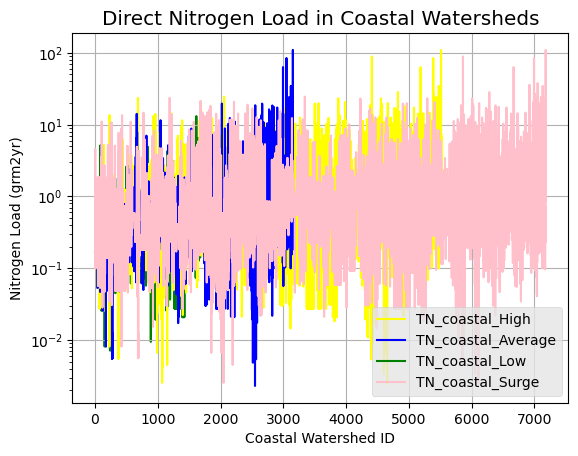

In [25]:

dfCoastalWatershed_high[CoastalDirectTN_high_convert].plot(color='yellow', label='TN_coastal_High')
dfCoastalWatershed_avg[CoastalDirectTN_avg_convert].plot(color='blue', label='TN_coastal_Average',zorder=2)
dfCoastalWatershed_low[CoastalDirectTN_low_convert].plot(color='green', label='TN_coastal_Low', zorder=1)
dfCoastalWatershed_surge[CoastalDirectTN_surge_convert].plot(color='pink', label='TN_coastal_Surge', zorder=3)
plt.xlabel('Coastal Watershed ID')
plt.ylabel('Nitrogen Load (grm2yr)')
plt.yscale('log')
plt.style.use('ggplot')
plt.title('Direct Nitrogen Load in Coastal Watersheds')
plt.grid()
plt.legend()
filename = 'Nitrogen_Load_in_Coastal_Watersheds.png'
outputname = os.path.join(outFig, filename)
plt.savefig(outputname)

## boxplot

C:\Users\abolmaal\AppData\Local\Temp\ipykernel_19892\2615294422.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Text(0.5, 1.0, 'Direct Nitrogen Load in Coastal Watersheds')

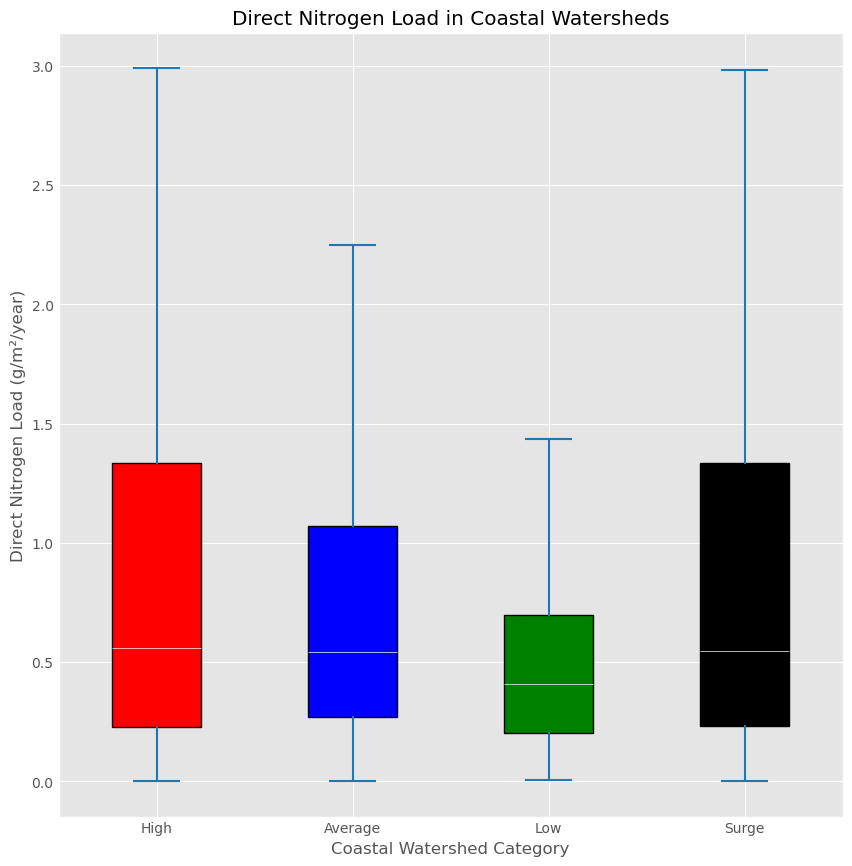

In [26]:
# Apply the '_mpl-gallery' style
plt.style.use('_mpl-gallery')

# Prepare the data using the updated field names
data_N = [
    dfCoastalWatershed_high[CoastalDirectTN_high_convert],
    dfCoastalWatershed_avg[CoastalDirectTN_avg_convert],
    dfCoastalWatershed_low[CoastalDirectTN_low_convert],
    dfCoastalWatershed_surge[CoastalDirectTN_surge_convert]
]

# Calculate the mean and standard deviation for each category (optional)
means = [d.mean() for d in data_N]
stds = [d.std() for d in data_N]

# Create the box plot
fig, ax = plt.subplots(figsize=(8, 8))
box = ax.boxplot(
    data_N,
    labels=['High', 'Average', 'Low', 'Surge'],
    patch_artist=True,
    showmeans=False,
    meanline=False,
    medianprops={"color": "white", "linewidth": 0.5},
    whiskerprops={"color": "C0", "linewidth": 1.5},
    capprops={"color": "C0", "linewidth": 1.5},
    meanprops={"color": "red", "linewidth": 1.5},
    showfliers=False
)

# Set different colors for each box
colors = ['red', 'blue', 'green', 'black']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set labels and title
plt.xlabel('Coastal Watershed Category')
plt.ylabel('Direct Nitrogen Load (g/m²/year)')
plt.title('Direct Nitrogen Load in Coastal Watersheds')

In [ ]:
# Apply the '_mpl-gallery' style
plt.style.use('_mpl-gallery')

# Prepare the data (ensure these are numeric lists)
data_P = [
    dfCoastalWatershed_high[fieldCoastalTP_high],
    dfCoastalWatershed_avg[fieldCoastalTP_avg],
    dfCoastalWatershed_low[fieldCoastalTP_low],
    dfCoastalWatershed_surge[fieldCoastalTP_surge]
]

# Calculate the mean and standard deviation for each category
means = [np.mean(d) for d in data_P]
stds = [np.std(d) for d in data_P]

# Plot the box plot
fig, ax = plt.subplots(figsize=(8, 8))
box = ax.boxplot(data_P, labels=['High', 'Average', 'Low', 'Surge'], patch_artist=True, showmeans=True, meanline=True,
                 medianprops={"color": "white", "linewidth": 0.5},
                 whiskerprops={"color": "C0", "linewidth": 1.5},
                 capprops={"color": "C0", "linewidth": 1.5},
                 meanprops={"color": "red", "linewidth": 1.5},
                 showfliers=False)

# Set different colors for each box
colors = ['red', 'blue', 'green', 'black']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set labels and title
plt.xlabel('Coastal Watershed Category')
plt.ylabel('Phosphorus Load (kgcellday)')
plt.title('Phosphorus Load in Coastal Watersheds')

filename = 'Phosphorus_Load_in_Coastal_Watersheds_boxplot.png'
output_path = os.path.join(outFig, filename)
plt.savefig(output_path, dpi= 300)
